## One compartment iv bonus ##

$$ \frac{dC}{dt} = -\frac{Cl}{V} \cdot C = -K \cdot C $$

$$ C = \frac{D}{V} \cdot e^{-\frac{Cl}{V} \cdot t} = \frac{D}{V} \cdot e^{-K \cdot t} = C^0 \cdot e^{-K \cdot t} $$

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import tellurium
from scipy.stats import linregress
import numpy as np
from scipy.integrate import solve_ivp

### 1. load data ###

In [71]:
data = {
        'Time (min)': [10, 20, 30, 40, 50, 60, 70, 90, 110, 150],
        'Subject 1 (µg·L⁻¹)': [920, 800, 750, 630, 610, 530, 520, 380, 350, 200],
        'Subject 2 (µg·L⁻¹)': [850, 630, 580, 410, 400, 270, 260, 145, 120, 42],
        'Subject 3 (µg·L⁻¹)': [800, 680, 550, 465, 370, 320, 245, 185, 110, 60],
        'Subject 4 (µg·L⁻¹)': [465, 400, 380, 330, 300, 290, 245, 185, 110, 120]
    }

dose = 10000 # μg
df = pd.DataFrame(data)

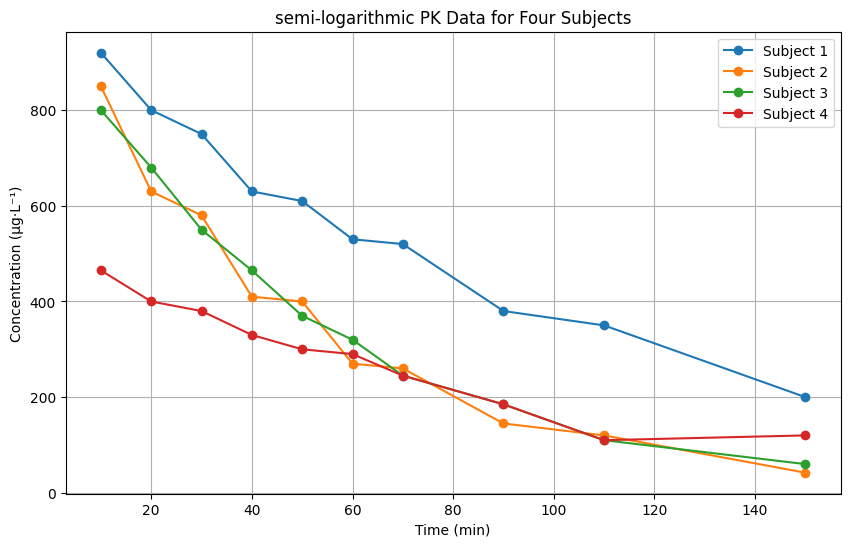

In [8]:
# 绘制曲线
plt.figure(figsize=(10, 6))
for i in range(1, 5):
    subject_col = f'Subject {i} (µg·L⁻¹)'
    plt.plot(df['Time (min)'], df[subject_col], label=f'Subject {i}', marker='o')
    
plt.xlabel('Time (min)')
plt.ylabel('Concentration (µg·L⁻¹)')
plt.title('semi-logarithmic PK Data for Four Subjects')
plt.legend()
plt.grid(True)
plt.show()

### 2. initial parameters estimates ###

In [72]:
slope_dict = {} # min-1
half_life_dict = {} # min
intercept_dict = {}
for col in df.columns:
    if col != 'Time (min)':
        x = df['Time (min)']
        y = np.log(df[col])

        # 执行线性回归
        slope, intercept, r_value, p_value, std_err = linregress(x, y)

        # 存储斜率，使用列名作为键
        slope_dict[col] = slope
        intercept_dict[col] = intercept  # 截距是lnC0

        # 计算半衰期，使用斜率的绝对值
        # 检查斜率是否为0，避免除以零错误
        if slope != 0:
            half_life = np.log(2) / abs(slope)
            half_life_dict[col] = half_life
        else:
            half_life_dict[col] = float('inf') # 如果斜率为0，半衰期为无穷大

print("每个受试者的斜率 (DataFrame 形式):")
slope_df = pd.DataFrame.from_dict(slope_dict, orient='index', columns=['Slope (min⁻¹)'])
ke_cal = slope_df['Slope (min⁻¹)'].mean()

print(slope_df)
print("均值是：")
print(ke)

print('每个受试者的截距(lnC0)是：')
intercept_dict = pd.DataFrame.from_dict(intercept_dict, orient='index', columns=['intercept(lnC0)'])
intercept_cal = intercept_dict['intercept(lnC0)'].mean()
c0 = np.exp(intercept_cal)
v = dose / c0
print(intercept_dict)
print(f'均值是{intercept_cal}')
print(f'C0是{c0}')
print(f'分布容积是{v}')



print("\n每个受试者的半衰期 (DataFrame 形式):")
half_life_df = pd.DataFrame.from_dict(half_life_dict, orient='index', columns=['Half-Life (min)'])
print(half_life_df)
print("均值是：")
print(half_life_df['Half-Life (min)'].mean())

每个受试者的斜率 (DataFrame 形式):
                    Slope (min⁻¹)
Subject 1 (µg·L⁻¹)      -0.010441
Subject 2 (µg·L⁻¹)      -0.020824
Subject 3 (µg·L⁻¹)      -0.018919
Subject 4 (µg·L⁻¹)      -0.010984
均值是：
-0.015291961321770558
每个受试者的截距(lnC0)是：
                    intercept(lnC0)
Subject 1 (µg·L⁻¹)         6.918913
Subject 2 (µg·L⁻¹)         6.934162
Subject 3 (µg·L⁻¹)         6.877619
Subject 4 (µg·L⁻¹)         6.237571
均值是6.742066268816961
C0是847.3096979230066
分布容积是11.80206012572829

每个受试者的半衰期 (DataFrame 形式):
                    Half-Life (min)
Subject 1 (µg·L⁻¹)        66.387657
Subject 2 (µg·L⁻¹)        33.286246
Subject 3 (µg·L⁻¹)        36.636721
Subject 4 (µg·L⁻¹)        63.107216
均值是：
49.8544599934865


### 3.simulation ###

In [65]:
# 定义微分方程
def one_comp_iv_bonus_ode(t, y, ke):
    drug = y[0]
    dc_dt = ke * drug
    return [dc_dt]

In [66]:
# 定义模型参数
ke = ke_cal

# 定义时间范围
t_span = (0, 200)

# 定义输出时间点
t_eval = np.linspace(0, 200, 20) # 在0-200范围内取20个点

# 初始条件
y0 = [c0]

In [67]:
# 求解微分方程
sol = solve_ivp(one_comp_iv_bonus_ode, t_span, y0, t_eval=t_eval, args=(ke,), method='RK45', rtol=1e-8)

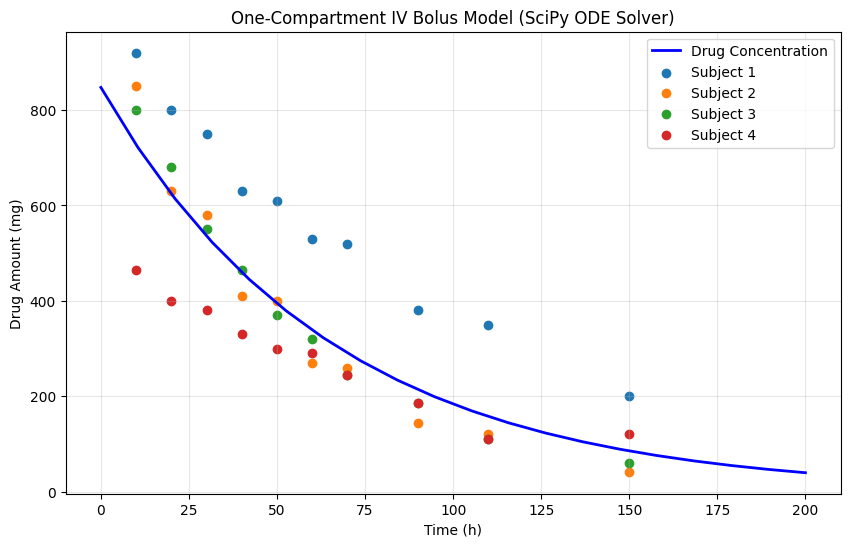

In [68]:
# 作图
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], 'b-', linewidth=2, label='Drug Concentration') # 此处注意，有几个微分方程就就会算出几个y，顺序是按照微分方程定义的顺序排列的
for i in range(1, 5):
    subject_col = f'Subject {i} (µg·L⁻¹)'
    plt.scatter(df['Time (min)'], df[subject_col], label=f'Subject {i}')
plt.xlabel('Time (h)')
plt.ylabel('Drug Amount (mg)')
plt.title('One-Compartment IV Bolus Model (SciPy ODE Solver)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

### popPK分析过程 ###

In [86]:
# 数据集的转化
long_data = []    
for i in range(1, 5):  # Subject 1-4
    subject_col = f'Subject {i} (µg·L⁻¹)'
    for j, time in enumerate(df['Time (min)']):
        long_data.append({
            'ID': i,
            'TIME': time,
            'CONC': df[subject_col].iloc[j],
            'DOSE': 10000 if time == 0 else 0  # 假设在t=10min时给药1000µg
            })
long_data = pd.DataFrame(long_data)

In [96]:
from scipy.optimize import curve_fit

# 为每个个体拟合参数
def one_comp_iv_bonus_model(t, c0, ke): # 此处的顺序要和curve_fit的顺序保持一致
    return c0 * np.exp(-ke*t)

results = []
for subject_id in long_data['ID'].unique():
    subject_data = long_data[long_data['ID']==subject_id].copy()

    try:
        popt, pcov = curve_fit(
            one_comp_iv_bonus_model,
            subject_data['TIME'],  # 第一个参数应该传入自变量
            subject_data['CONC'],  # 第二个参数是因变量
            p0 =[1000, 0.01], # 初始猜测值
            bounds=([0,0], [np.inf, 1])
        )
        C0, ke = popt

        dose = 10000  # µg，假设剂量
        Vd = dose / C0  # 分布容积 (L)
        CL = Vd * ke    # 清除率 (L/min)
        t_half = np.log(2) / ke  # 半衰期 (min)

        # 计算拟合优度 (R²)
        y_pred = one_comp_iv_bonus_model(subject_data['TIME'], C0, ke)
        ss_res = np.sum((subject_data['CONC'] - y_pred) ** 2)
        ss_tot = np.sum((subject_data['CONC'] - np.mean(subject_data['CONC'])) ** 2)
        r_squared = 1 - (ss_res / ss_tot)

        results.append({
                'ID': subject_id,
                'C0 (µg/L)': C0,
                'ke (1/min)': ke,
                'Vd (L)': Vd,
                'CL (L/min)': CL,
                't1/2 (min)': t_half,
                'R²': r_squared
            })
    except Exception as e:
        print(f"个体 {subject_id} 拟合失败: {e}")
results = pd.DataFrame(results) 
print(results)

   ID    C0 (µg/L)  ke (1/min)     Vd (L)  CL (L/min)  t1/2 (min)        R²
0   1  1002.161324    0.010256   9.978433    0.102340   67.583838  0.990131
1   2  1018.720596    0.020661   9.816234    0.202816   33.548077  0.987164
2   3   978.186855    0.019041  10.222996    0.194659   36.402413  0.998567
3   4   518.687145    0.011128  19.279444    0.214550   62.286139  0.974079


In [97]:
# 计算群体典型值

# 需要计算群体参数的列（排除ID和R²）
pk_params = ['C0 (µg/L)', 'ke (1/min)', 'Vd (L)', 'CL (L/min)', 't1/2 (min)']

# 对数正态分布参数（通常用于PK参数）
log_normal_params = ['Vd (L)', 'CL (L/min)', 'ke (1/min)', 't1/2 (min)']

pop_summary = []

for param in pk_params:
    values = results[param].dropna()    
    if len(values) == 0:
        continue    
    
    if param in log_normal_params:
        # 对数正态分布分析
        log_values = np.log(values)
        geometric_mean = np.exp(np.mean(log_values))
        cv_percent = np.sqrt(np.exp(np.var(log_values)) - 1) * 100
            
        pop_summary.append({
                'Parameter': param,
                'Typical Value': geometric_mean,
                'CV (%)': cv_percent,
                'Distribution': 'Log-normal',
                'Min': values.min(),
                'Max': values.max(),
                'N': len(values)
            })
    else:
        # 正态分布分析
        mean_val = np.mean(values)
        std_val = np.std(values)
        cv_percent = (std_val / mean_val) * 100 if mean_val != 0 else 0
            
        pop_summary.append({
            'Parameter': param,
            'Typical Value': mean_val,
            'CV (%)': cv_percent,
            'Distribution': 'Normal',
            'Min': values.min(),
            'Max': values.max(),
            'N': len(values)
            })

In [100]:
pd.DataFrame(pop_summary)

,Parameter,Typical Value,CV (%),Distribution,Min,Max,N
0,C0 (µg/L),879.438980,23.739918,Normal,518.687145,1018.720596,4
1,ke (1/min),0.014557,31.980806,Log-normal,0.010256,0.020661,4
2,Vd (L),11.787453,29.027597,Log-normal,9.816234,19.279444,4
3,CL (L/min),0.171588,30.726958,Log-normal,0.102340,0.214550,4
4,t1/2 (min),47.616560,31.980806,Log-normal,33.548077,67.583838,4


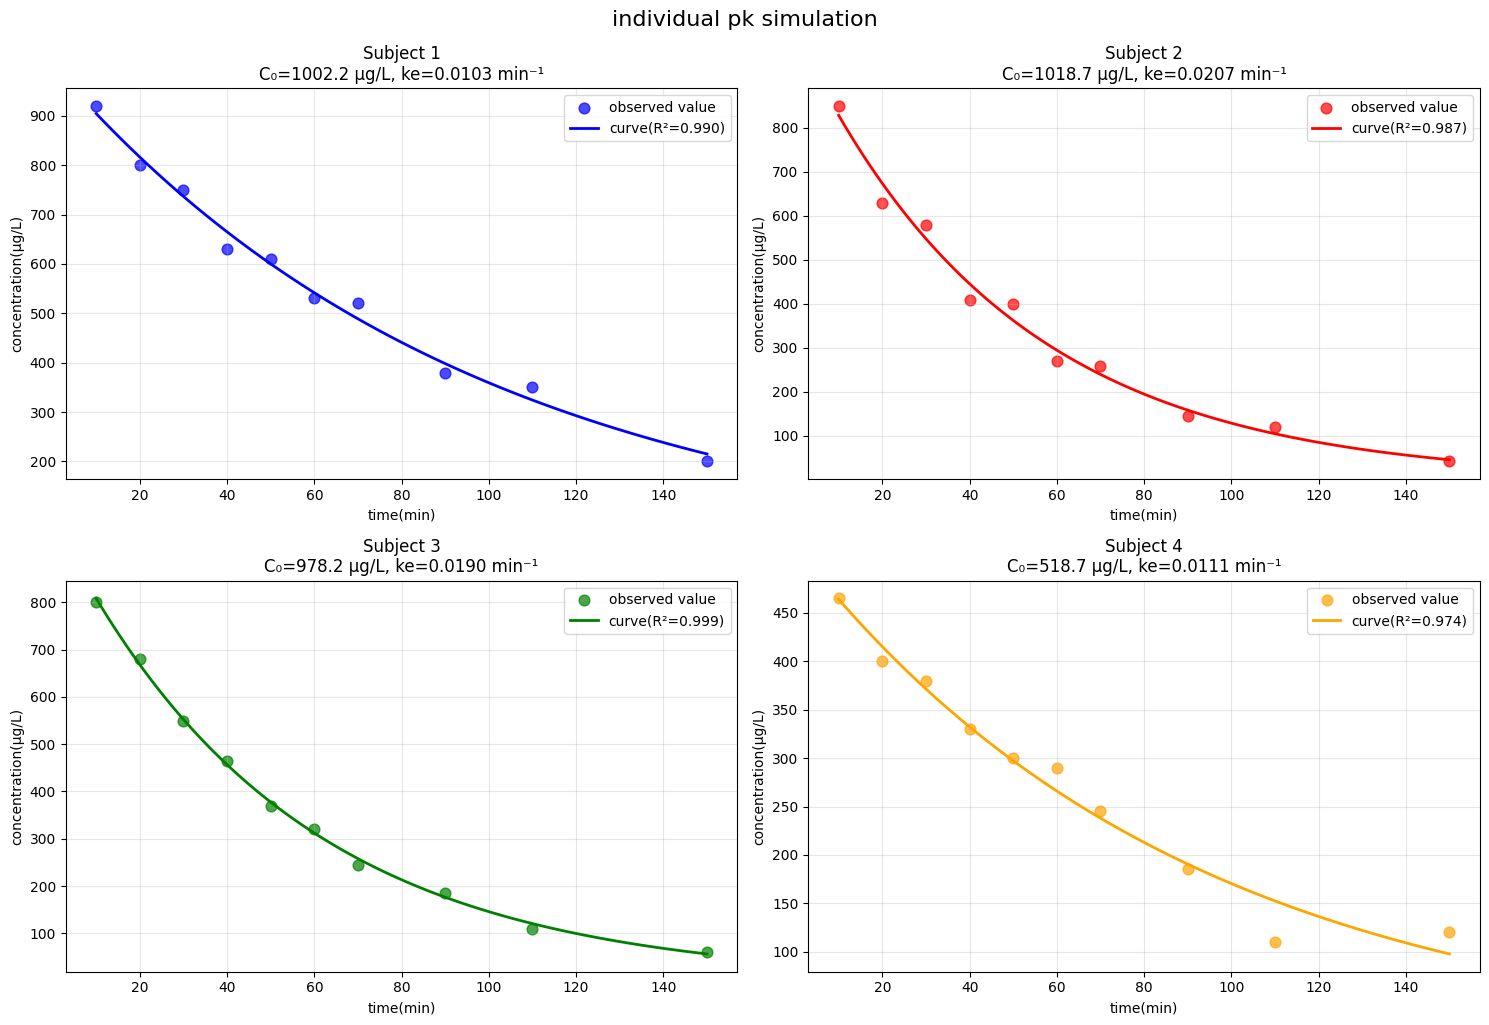

In [104]:
# 绘制个体曲线
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
    
colors = ['blue', 'red', 'green', 'orange']
    
for i, subject_id in enumerate(sorted(long_data['ID'].unique())):
    ax = axes[i]
        
    # 获取个体数据
    subject_data = long_data[long_data['ID'] == subject_id]
    subject_params = results[results['ID'] == subject_id]
        
    if len(subject_params) > 0 and not pd.isna(subject_params['C0 (µg/L)'].iloc[0]):
        C0 = subject_params['C0 (µg/L)'].iloc[0]
        ke = subject_params['ke (1/min)'].iloc[0]
        r_squared = subject_params['R²'].iloc[0]
            
        # 绘制观测数据
        ax.scatter(subject_data['TIME'], subject_data['CONC'], 
                      color=colors[i], s=60, alpha=0.7, label='observed value')
            
        # 绘制拟合曲线
        t_fit = np.linspace(subject_data['TIME'].min(), subject_data['TIME'].max(), 100)
        c_fit = one_comp_iv_bonus_model(t_fit, C0, ke)
        ax.plot(t_fit, c_fit, color=colors[i], linewidth=2, 
                   label=f'curve(R²={r_squared:.3f})')
            
        ax.set_title(f'Subject {subject_id}\nC₀={C0:.1f} µg/L, ke={ke:.4f} min⁻¹')
    else:
        # 拟合失败的情况
        ax.scatter(subject_data['TIME'], subject_data['CONC'], 
                      color=colors[i], s=60, alpha=0.7, label='observed value')
        ax.set_title(f'Subject {subject_id}\n拟合失败')
        
    ax.set_xlabel('time(min)')
    ax.set_ylabel('concentration(µg/L)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
plt.tight_layout()
plt.suptitle('individual pk simulation', fontsize=16, y=1.02)
plt.show()